In [1]:
import xarray as xr
import pyfesom2 as pf
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pylab as plt

In [2]:
def interpolate_kdtree2d(
    data_in,
    x2,
    y2,
    lons,
    lats,
    distances,
    inds,
    radius_of_influence=50000,
    mask_zero=True,
):
    """Interpolates from points of unstructured mesh to regular grid.
    This version puts NaN where values are not present."""

    interpolated = data_in[inds]
    interpolated[distances >= radius_of_influence] = np.nan
    if mask_zero:
        interpolated[interpolated == 0] = np.nan
    interpolated.shape = lons.shape

    return interpolated

Load mesh

In [3]:
mesh = pf.load_mesh('/work/ollie/projects/clidyn/FESOM2/meshes/core2/')

/work/ollie/projects/clidyn/FESOM2/meshes/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/projects/clidyn/FESOM2/meshes/core2/pickle_mesh_py3_fesom2


Create target regular grid:

In [4]:
# lon = np.linspace(0.5, 359.5, 360)
# lat = np.linspace(-89.5, 89.5, 180)
# lon2, lat2 = np.meshgrid(lon, lat)
lon = np.linspace(0, 360, 360*4)
lat = np.linspace(-90, 90, 180*4)
lon2, lat2 = np.meshgrid(lon, lat)

Convert model longitudes to [0...360] format

In [5]:
model_lon = np.where(mesh.x2<0, mesh.x2+360, mesh.x2)

Compute distances and indices fro neares neighbour interploation:

In [6]:
distances, inds = pf.create_indexes_and_distances(mesh, lon2, lat2, k=1)

Read data that we would like to interpolate:

In [8]:
ttemp = xr.open_dataset('/work/ollie/nkolduno/samuel/temp.fesom.1977.nc')
ssalt = xr.open_dataset('/work/ollie/nkolduno/samuel/salt.fesom.1977.nc')

Prepear empty array, that we will fill with data:

In [9]:
ttemp_interp=np.zeros((mesh.zlev.shape[0]-1, lon2.shape[0], lon2.shape[1]))

Interpolation for temperature. We take first time step. You might want to adjust radius_of_influence. We also put mask_zero=True to have NaN where we don't have temperature.

In [10]:
variable = 'temp'
for dd in range(ttemp[variable].shape[2]):
    interpolated = interpolate_kdtree2d(ttemp[variable][0,:,dd].values,
                                        model_lon, mesh.y2, lon2, lat2, distances, inds, mask_zero=True,
                                       radius_of_influence=200000)
    ttemp_interp[dd,:,:] = interpolated

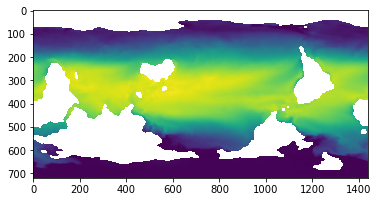

In [11]:
plt.imshow(ttemp_interp[0,:,:])

In [60]:
out1 = xr.Dataset(
        {variable: (["depth", "lat", "lon"], ttemp_interp)},
        coords={
            "depth": mesh.zlev[:-1],
            "lon": (["lon"], lon),
            "lat": (["lat"], lat),
        },
    )

Save the data

In [61]:
out1.to_netcdf('int_temp4.nc')

Same procedure for salinity

In [13]:
ssalt_interp=np.zeros((mesh.zlev.shape[0]-1, lon2.shape[0], lon2.shape[1]))

In [14]:
variable = 'salt'
for dd in range(ssalt[variable].shape[2]):
    interpolated = interpolate_kdtree2d(ssalt[variable][0,:,dd].values,
                                        model_lon, mesh.y2, lon2, lat2, distances, inds, mask_zero=True,
                                       radius_of_influence=200000)
    ssalt_interp[dd,:,:] = interpolated

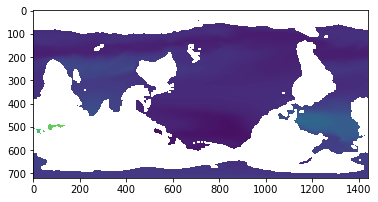

In [15]:
plt.imshow(ssalt_interp[20,:,:])

In [16]:
out1 = xr.Dataset(
        {variable: (["depth", "lat", "lon"], ssalt_interp)},
        coords={
            "depth": mesh.zlev[:-1],
            "lon": (["lon"], lon),
            "lat": (["lat"], lat),
        },
    )

In [17]:
out1.to_netcdf('int_salt4.nc')